##### How can user review/feedback be effectively grouped to identify key areas for app improvement? / Can we Identify common technical issues and feature request based on user reviews to improve the application user experience?

In [38]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
df = pd.read_csv('gcash-2023-formatted.csv')

In [40]:
df.head()

,Unnamed: 0.1,Unnamed: 0,review_text,review_rating,review_datetime_utc,review_likes,review_text_formatted
0,454628,454628,Gcash Wallet,5,2023-01-01T00:24:41.000Z,0,NaN
1,454629,454629,"When I open my g-cash, I got to choose later &...",1,2023-01-01T00:41:06.000Z,0,"['open', 'gcash', 'get', 'choose', 'late', 'tr..."
2,454630,454630,Need this,5,2023-01-01T01:40:05.000Z,0,NaN
3,454631,454631,Stupid app i used my original psa but they tol...,1,2023-01-01T01:46:15.000Z,0,"['stupid', 'application', 'use', 'original', '..."
4,454632,454632,app keeps disappearing,1,2023-01-01T02:07:54.000Z,0,"['application', 'keep', 'disappearing']"


# Data Pre-Processing

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75320 entries, 1 to 133049
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_text            75320 non-null  object
 1   review_rating          75320 non-null  int64 
 2   review_likes           75320 non-null  int64 
 3   review_text_formatted  75320 non-null  object
 4   text_length            75320 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.4+ MB


In [42]:
print(df.isna().sum())

Unnamed: 0.1                 0
Unnamed: 0                   0
review_text                  0
review_rating                0
review_datetime_utc          0
review_likes                 0
review_text_formatted    52424
dtype: int64


In [43]:
print(df['review_rating'].value_counts())

review_rating
1    61850
5    48252
2     8954
3     7733
4     6261
Name: count, dtype: int64


In [44]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0','review_datetime_utc'], inplace=True)
df.dropna(inplace=True)

In [45]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
1,"When I open my g-cash, I got to choose later &...",1,0,"['open', 'gcash', 'get', 'choose', 'late', 'tr..."
3,Stupid app i used my original psa but they tol...,1,0,"['stupid', 'application', 'use', 'original', '..."
4,app keeps disappearing,1,0,"['application', 'keep', 'disappearing']"
7,Good but I can't dl it anymore why?,5,0,"['good', 'negativelabel', 'download', 'anymore']"
9,Lage nawawala sa cp ko di ko.alam kung bakit.,1,0,"['palagi', 'nawawala', 'phone', 'alam']"


In [46]:
import re

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: re.sub(r"[\[\]']", '', x)  # Removes [, ], and ' characters
)

df['review_text_formatted'] = df['review_text_formatted'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
)

In [47]:
df.head()

,review_text,review_rating,review_likes,review_text_formatted
1,"When I open my g-cash, I got to choose later &...",1,0,open gcash get choose late try gcash icon auto...
3,Stupid app i used my original psa but they tol...,1,0,stupid application use original psa tell verif...
4,app keeps disappearing,1,0,application keep disappearing
7,Good but I can't dl it anymore why?,5,0,good negativelabel download anymore
9,Lage nawawala sa cp ko di ko.alam kung bakit.,1,0,palagi nawawala phone alam


In [48]:
print(df.duplicated(subset=['review_text_formatted']).sum())
df = df.drop_duplicates(subset=['review_text_formatted'])

5306


# Exploratory Data Analysis

Top 20 Most Frequent Words in Reviews

In [49]:
from collections import Counter

word_list = df['review_text_formatted'].str.split().explode()  # Flatten tokenized words
word_freq = Counter(word_list)

# View top 20 words
print(word_freq.most_common(20))

[('negativelabel', 47101), ('application', 32531), ('gcash', 25791), ('update', 19339), ('open', 11664), ('account', 10820), ('money', 10480), ('use', 10183), ('always', 9454), ('need', 7908), ('verify', 6872), ('ninyo', 6529), ('please', 6487), ('fix', 6117), ('time', 6084), ('good', 5572), ('even', 5362), ('say', 5287), ('keep', 4933), ('log', 4607)]


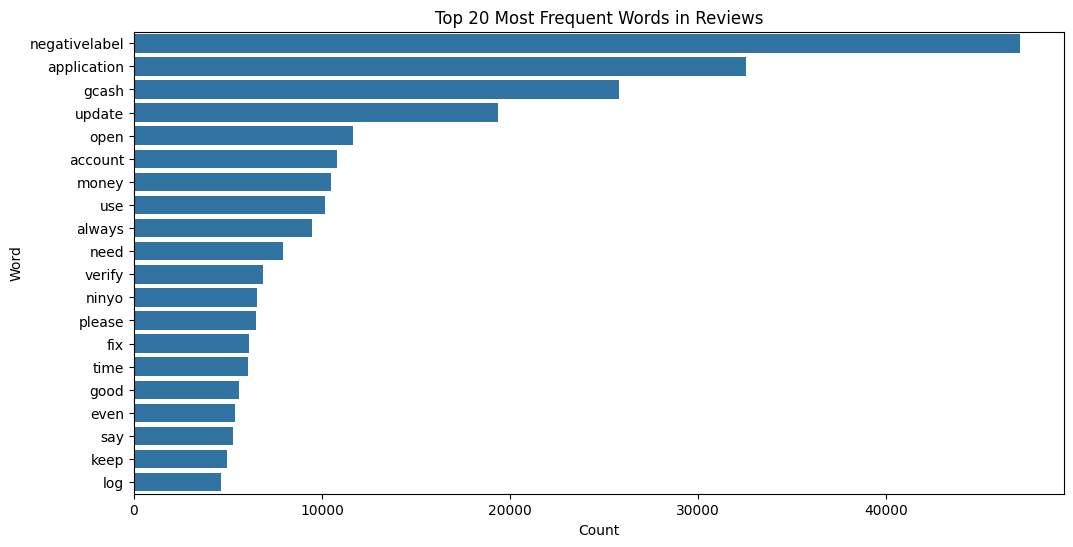

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd

top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words)
plt.title("Top 20 Most Frequent Words in Reviews")
plt.show()


Distribution of Review Lengths

In [51]:
df['text_length'] = df['review_text_formatted'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())  # Summary stats

count    75320.000000
mean        11.001567
std          9.223859
min          3.000000
25%          5.000000
50%          8.000000
75%         14.000000
max         84.000000
Name: text_length, dtype: float64


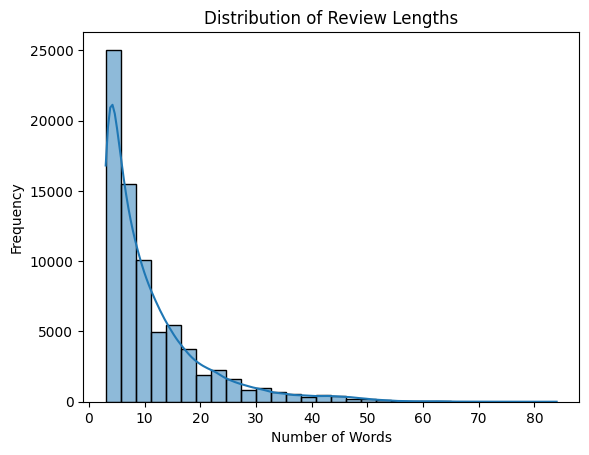

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['text_length'], bins=30, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()


# Feature Representation

We will be testing both TF-IDF and Multilingual BERT (mBERT) (FilipinoBERT)

TF-IDF - Fast and simple but requires stopwords to prevent those words from being the top words <br>
FilipinoBERT - Meaningful and context-aware but requires more setup

In [53]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['review_text_formatted']).toarray()

In [54]:
df_tfidf = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
print(df_tfidf)

       100x  10th  10x  11th  1gb  1hour  1st  1star  1week  1yr  ...  yuck  \
0       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
1       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
2       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
3       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
4       0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
...     ...   ...  ...   ...  ...    ...  ...    ...    ...  ...  ...   ...   
75315   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
75316   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
75317   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
75318   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   
75319   0.0   0.0  0.0   0.0  0.0    0.0  0.0    0.0    0.0  0.0  ...   0.0   

       yumayaman  yun  yungcash  yunh   yw  ywa  ze

In [56]:
"yes"

'yes'